# Analyzing table data

We will be analyzing temperature (in C) and discharge data (in cubic feet per second) from the [Middle Fork of the Willamette River](https://en.wikipedia.org/wiki/Middle_Fork_Willamette_River) near Jasper. 

## Visualize

With any new project, it is usually a good practice to visualize the data to get a sense of what we are working with.

In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
df = pd.read_csv('data/middle_fork_willamette.csv', parse_dates=['date'], index_col=['date'])
df

,temp,discharge
date,,
2020-09-30,14.0,3470.0
2020-10-01,14.2,3460.0
2020-10-02,14.3,3250.0
2020-10-03,14.4,3070.0
2020-10-04,14.7,3040.0
...,...,...
2021-09-27,16.9,1900.0
2021-09-28,16.5,1970.0
2021-09-29,16.6,NaN


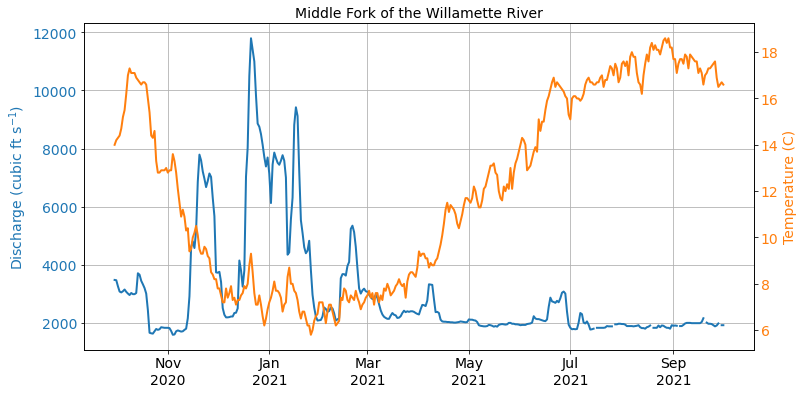

In [132]:
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(df['discharge'], linewidth=2, label='discharge')
ax1.set_title('Middle Fork of the Willamette River', fontsize=14)
ax1.tick_params(axis='both', labelsize=14)
ax1.set_ylabel('Discharge (cubic ft s$^{-1}$)', fontsize=14, color='C0')
ax1.tick_params(axis='both', labelsize=14)
ax1.tick_params(axis='y', labelcolor='C0')

ax2 = ax1.twinx()  # add a second axes that shares the same x-axis
ax2.plot(df['temp'], color='C1', linewidth=2, label='temperature')
ax2.tick_params(axis='y', labelcolor='C1')
ax2.tick_params(axis='both', labelsize=14)
ax2.set_ylabel('Temperature (C)', fontsize=14, color='C1')

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
ax1.grid()

plt.show()

## Missing values

The first stage of data cleaning and preparation involves handling missing values which are a feature of nearly all "real life" datasets. Before handling missing values, we need to count the number of missing values in the DataFrame. We can use the [`info()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html) method to provide information about a DataFrame including the data types, column names, non-null values, and memory usage.

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 367 entries, 2020-09-30 to 2021-10-01
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   temp       367 non-null    float64
 1   discharge  361 non-null    float64
dtypes: float64(2)
memory usage: 8.6 KB


From the data summary, we can see that there are six missing (or null) values in the dicharge column. There are many ways to handle these values and there is no "best" way that can be used for every task. We will zoom in on one of these missing values to demonstrate.

In [73]:
df_missing = df[286:293]
df_missing

,temp,discharge
date,,
2021-07-13,16.7,1760.0
2021-07-14,16.7,1770.0
2021-07-15,16.6,1790.0
2021-07-16,16.6,NaN
2021-07-17,16.7,1820.0
2021-07-18,16.7,1820.0
2021-07-19,16.9,1820.0


We have a missing value on July 16. One option we have is to drop this value completely by making a **boolean mask** that depends on whether the discharge value is `notna()`.

In [74]:
df_missing[df_missing['discharge'].notna()]

,temp,discharge
date,,
2021-07-13,16.7,1760.0
2021-07-14,16.7,1770.0
2021-07-15,16.6,1790.0
2021-07-17,16.7,1820.0
2021-07-18,16.7,1820.0
2021-07-19,16.9,1820.0


We can also fill the missing values with the values that come before or after it using [`fillna`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html). This method is used quite often in time series analysis. The `ffill` method will **propagate forward**, filling the missing value with the value before. The `bfill` method will **propagate backward**, filling the missing value with the value after.

In [75]:
df_missing.fillna(method='ffill')

,temp,discharge
date,,
2021-07-13,16.7,1760.0
2021-07-14,16.7,1770.0
2021-07-15,16.6,1790.0
2021-07-16,16.6,1790.0
2021-07-17,16.7,1820.0
2021-07-18,16.7,1820.0
2021-07-19,16.9,1820.0


In [76]:
df_missing.fillna(method='bfill')

,temp,discharge
date,,
2021-07-13,16.7,1760.0
2021-07-14,16.7,1770.0
2021-07-15,16.6,1790.0
2021-07-16,16.6,1820.0
2021-07-17,16.7,1820.0
2021-07-18,16.7,1820.0
2021-07-19,16.9,1820.0


We could also linearly [`interpolate`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html) the missing value using the values before and after.

In [77]:
df_missing.interpolate()

,temp,discharge
date,,
2021-07-13,16.7,1760.0
2021-07-14,16.7,1770.0
2021-07-15,16.6,1790.0
2021-07-16,16.6,1805.0
2021-07-17,16.7,1820.0
2021-07-18,16.7,1820.0
2021-07-19,16.9,1820.0


We will apply this method to the whole dataset so that we no longer have any missing values.

In [78]:
df = df.interpolate()
df.isnull().sum()

temp         0
discharge    0
dtype: int64

## Resample

Since `Pandas` is "aware" that our index column represents dates, we can easily [`resample`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html) our data to a a different sampling frequency. For example, we can produce a **mean monthly** temperature record:

In [103]:
df_monthly_mean = df['temp'].resample('1M').mean()
df_monthly_mean.head()

date
2020-09-30    14.000000
2020-10-31    15.238710
2020-11-30    10.470000
2020-12-31     7.503226
2021-01-31     7.161290
Freq: M, Name: temp, dtype: float64

```{tip} The frequencies after `resample` are called **offset aliases**. A table of valid offset aliases can be found here: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
```

Alternatively, instead of averaging the temperatures in each month, we could **sum** the **discharges** in each month:

In [104]:
df_monthly_sum = df['discharge'].resample('1M').sum()
df_monthly_sum.head()

date
2020-09-30      3470.0
2020-10-31     81990.0
2020-11-30    124590.0
2020-12-31    175360.0
2021-01-31    180890.0
Freq: M, Name: discharge, dtype: float64

We could also choose different time frequency such as the median over 10 days.

In [105]:
df_10day_mean = df['discharge'].resample('10D').median()
df_10day_mean.head()

date
2020-09-30    3075.0
2020-10-10    3105.0
2020-10-20    1760.0
2020-10-30    1720.0
2020-11-09    2530.0
Freq: 10D, Name: discharge, dtype: float64

Resampling is useful for summarizing our data at different temporal frequencies so we can reliably compare one year to the next. We can plot one of the resampled data to check that it looks right. 

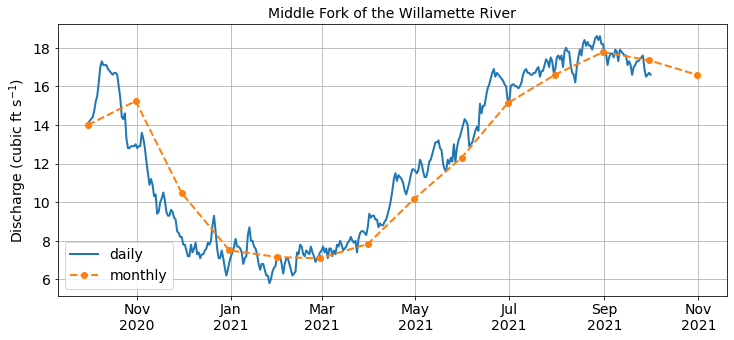

In [125]:
fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.plot(df['temp'], linewidth=2, label='daily')
ax1.plot(df_monthly_mean, linewidth=2, marker='o', linestyle='dashed', label='monthly')
ax1.set_title('Middle Fork of the Willamette River', fontsize=14)
ax1.tick_params(axis='both', labelsize=14)
ax1.set_ylabel('Discharge (cubic ft s$^{-1}$)', fontsize=14)
ax1.tick_params(axis='both', labelsize=14)

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
ax1.grid()
ax1.legend(fontsize=14)

plt.show()

## Rolling windows

Similar to resampling, [rolling windows](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html) split and aggregate the data into time windows with a function such as `mean()`, `median()`, `sum()`, etc. However, unlike **resampling** where the bins do not overlap so the output is at a lower frequency than the input, **rolling windows** overlap (or "roll") along at the same frequency as the data, so the transformed time series is at the same frequency as the original time series.

In [118]:
weekly_discharge = df['discharge'].rolling(7, center=True).mean()
monthly_discharge = df['discharge'].rolling(30, center=True).mean()
seasonal_discharge = df['discharge'].rolling(91, center=True).mean()

```{note} 
We use the `center=True` argument to label each window at its midpoint
```

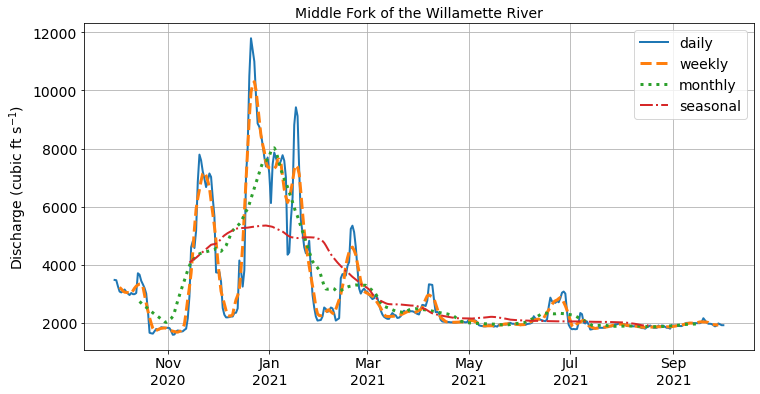

In [124]:
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(df['discharge'], linewidth=2, label='daily')
ax1.plot(weekly_discharge, linewidth=3, linestyle='dashed', label='weekly')
ax1.plot(monthly_discharge, linewidth=3, linestyle='dotted', label='monthly')
ax1.plot(seasonal_discharge, linewidth=2, linestyle='dashdot', label='seasonal')

ax1.set_title('Middle Fork of the Willamette River', fontsize=14)
ax1.tick_params(axis='both', labelsize=14)
ax1.set_ylabel('Discharge (cubic ft s$^{-1}$)', fontsize=14)
ax1.tick_params(axis='both', labelsize=14)

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
ax1.grid()
ax1.legend(fontsize=14)

plt.show()

As we can see from the figure above, the rolling windows are smoother than the original discharge data because higher frequency variability has been averaged out. These kind of operations can be useful for **removing noise** from our data.